In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import scipy
import scipy.spatial

In [26]:
def load_json(fname,decode=None):
    with open(fname, "r") as json_file:
        d = json.load(json_file)
    return d

def save_dict_to_json(dict_data, file_path):
    data = json.dumps(dict_data,indent=1)
    with open(file_path,'w',encoding='utf-8',newline='\n') as f:
        f.write(data)
        print("加载入文件完成...")

In [27]:
import pandas as pd

def read_csv(filename):
    try:
        df = pd.read_csv(filename, header=None) # 没有表头，设置header参数为None
    except pd.errors.EmptyDataError:
        # print("The file is empty.")
        df = pd.DataFrame() # 创建一个空的DataFrame对象
    return df.values.tolist() # 转换为列表返回

In [28]:
def draw_bbox(img,bboxes):
    deal_img = img.copy()
    for i in range(len(bboxes)):
        x1,y1,x2,y2,cls = bboxes[i]
        cls.astype("uint8")
        if(cls == 1):
            cv2.rectangle(
                deal_img,
                (x1.astype("uint16"), y1.astype("uint16")),
                (x2.astype("uint16"), y2.astype("uint16")),
                (0,255,0),
                2)
        if(cls == 2):
            cv2.rectangle(
                deal_img,
                (x1.astype("uint16"), y1.astype("uint16")),
                (x2.astype("uint16"), y2.astype("uint16")),
                (255,0,0),
                2)
    return deal_img

In [29]:
def cal_lk(x1,y1,x2,y2):
    sigma = 5
    distance = np.sqrt((x1-x2)**2+(y1-y2)**2)
    if(distance >= 20):
        return 0
    else:
        return np.exp(-(distance**2/sigma**2))

In [30]:
def deal_single_dimension(dim):
    crowd_range = np.max(dim) - np.min(dim) # range: y_max - y_min
    circle_scale = crowd_range / 6.

    dim_expand = []
    dim_expand.append(dim)
    dim_expand.append(np.zeros((len(dim))))
    dim_expand = np.transpose(np.array(dim_expand))

    tree = scipy.spatial.KDTree(dim_expand.copy(), leafsize=1024)      
    distances, distances_idx = tree.query(dim_expand, k=len(dim_expand))
    k = 3
    distances_mean = 0.5 * np.mean(distances[:,1:k],axis=1)   # 三个最近的点的均值

    return distances_mean

In [31]:
def generate_bbox_way2(centers):    # 第二种生成框的方式，生成的是矩形的bbox
    # add scale in bboxes height
    patch_size = 1024
    k = min(len(centers),4)
    if k <= 2:
        scale = max(patch_size / (4. + k), 12)
        scale = np.ones(k)* scale
        scale_weight = 0.1 if k==1 else 1.
        scale_weight = np.ones(k)* scale_weight
    else:
        # 计算注释点之间的两两距离并做一次距离的阈值筛选
        tree = scipy.spatial.KDTree(centers.copy(), leafsize=1024)
        crowd_range = np.max(centers[:,1]) - np.min(centers[:,1]) # range: y_max - y_min
        circle_scale = crowd_range / 6.
        distances, distances_idx = tree.query(centers, k=len(centers))

        # 三个最近的点距离的均值以及x,y方向上距离的均值
        distances_mean = 0.5 * np.mean(distances[:,1:k],axis=1)   
        x = centers[:,0]
        y = centers[:,1]
        
        x_mean = np.zeros((len(distances_mean)))
        y_mean = np.zeros((len(distances_mean)))
        for i in range(len(x_mean)):
            for j in range(k-1):
                x_mean[i] += 0.5 * np.abs(x[i] - x[distances_idx[i,j+1]])
                y_mean[i] += 0.5 * np.abs(y[i] - y[distances_idx[i,j+1]])
        
        # print(distances_mean)
        # print(x_mean)
        # print(y_mean)
        places = np.where(distances <= circle_scale)
        unique, counts = np.unique(places[0], return_counts=True) # places[0]: row index

        take_d_places = dict(zip(unique, counts))
        scale = []
        x_scale = []
        y_scale = []
        scale_weight = []
        for key,value in take_d_places.items():
            idx_in_circle = distances_idx[key, :value]
            s_p = np.mean(distances_mean[idx_in_circle])
            s_p = np.clip(s_p,8,None) #limit min size
            scale.append(s_p)

            x_p = np.mean(x_mean[idx_in_circle])
            x_p = np.clip(x_p,8,None) #limit min size
            x_scale.append(x_p)

            y_p = np.mean(y_mean[idx_in_circle])
            y_p = np.clip(y_p,8,None) #limit min size
            y_scale.append(y_p)
            scale_weight.append(value)

        scale = np.array(scale)
        x_scale = np.array(x_scale)
        y_scale = np.array(y_scale)
        scale_weight = np.array(scale_weight)

        boxes_with_scale = np.zeros((len(centers), 4))
        boxes_with_scale[:, 1], boxes_with_scale[:, 3] = centers[:, 0] - x_scale / 2., centers[:, 0] + x_scale / 2.
        boxes_with_scale[:, 0], boxes_with_scale[:, 2] = centers[:,1] - y_scale/2., centers[:,1] + y_scale/2.
        boxes_with_scale[:, 0:4:2] = np.clip(boxes_with_scale[:, 0:4:2], 0, patch_size - 1)
        boxes_with_scale[:, 1:4:2] = np.clip(boxes_with_scale[:, 1:4:2], 0, patch_size - 1)

        return boxes_with_scale

In [32]:
def generate_point_map(centers):
    patch_size = 1024
    point_map  = np.zeros((patch_size,patch_size))
    for i,center in enumerate(centers):
        x = center[0]
        y = center[1]
        point_map[x-5:x+5,y-5:y+5] = 1
    
    return point_map

In [33]:
def cal_lk(x1,y1,x2,y2):
    sigma = 5
    distance = np.sqrt((x1-x2)**2+(y1-y2)**2)
    
    return np.exp(-(distance**2/sigma**2))

def generate_heatmap(bboxes, heatmap_size):
    """
    在指定的边界框内生成高斯概率分布的热图。
    
    参数：
        bbox: 边界框，形如 [xmin, ymin, xmax, ymax]。
        heatmap_size: 热图的大小，为一个二元组 (H, W)，表示高和宽。
        sigma: 高斯核的标准差，默认值为 1.0。
    
    返回：
        生成的热图，范围从 0 到 1。
    """

    # 创建一张黑色背景的图像
    heatmap = np.zeros(heatmap_size, dtype=np.float32)
    for bbox in bboxes: # 只计算bbox内的概率热图
        center_x = (bbox[0] + bbox[2]) / 2
        center_y = (bbox[1] + bbox[3]) / 2
        for i in range(int(bbox[0]),int(bbox[2])):
            for j in range(int(bbox[1]),int(bbox[3])):
                # 计算边界框的中心点坐标
                lk = cal_lk(i,j,center_x,center_y)

                heatmap[j][i] = max(lk,heatmap[j][i])
            
    return heatmap

def generate_label(bboxes, label_size):
    """
    在指定的边界框内生成伪标签，以点标注为中心的半径12的圆形。
    
    """

    # 创建一张黑色背景的图像
    label = np.zeros(label_size, dtype=np.float32)
    for bbox in bboxes: # 只计算bbox内的概率热图
        cls_label = bbox[4]
        center_x = (bbox[0] + bbox[2]) / 2
        center_y = (bbox[1] + bbox[3]) / 2

        x_min = max(0,int(center_x - 12))
        x_max = min(1023,int(center_x + 12))
        y_min = max(0,int(center_y - 12))
        y_max = min(1023,int(center_y + 12))
        for i in range(x_min,x_max):
            for j in range(y_min,y_max):
                # 计算边界框的中心点坐标
                if(np.sqrt((i-center_x)**2+(j-center_y)**2)<=12):
                    label[j][i] = cls_label
            
    return label

In [34]:
data_dir = '/data114_1/ocelot2023_v0.1.2'
mode = 'train'
type = 'cell'


img_dir = os.path.join(data_dir,'images',mode,type)
img_paths = os.listdir(img_dir)
img_paths.sort()

ann_dir = os.path.join(data_dir,'annotations',mode,type)
ann_paths = os.listdir(ann_dir)
ann_paths.sort()

if not os.path.exists(os.path.join(data_dir,'annotations',mode,'masks')):
    os.makedirs(os.path.join(data_dir,'annotations',mode,'masks'))

if not os.path.exists(os.path.join(data_dir,'annotations',mode,'heatmap')):
    os.makedirs(os.path.join(data_dir,'annotations',mode,'heatmap'))


In [35]:
import tqdm
cnt_img = 0
cnt_bbox = 0

pbar = tqdm.tqdm(total=len(ann_paths))

for i,ann_path in enumerate(ann_paths):
    file_name = ann_path.split('.')[0]
    img = cv2.imread(os.path.join(img_dir,img_paths[i]))
    width = img.shape[1]
    height = img.shape[0]
    data = read_csv(os.path.join(ann_dir,ann_path))
    data = np.array(data)

    if len(data) > 2:
        cnt_img += 1
        centers = data[:,0:2]
        centers[:,[0,1]] = centers[:,[1,0]]
        cls = data[:,2]

        boxes_with_scale = generate_bbox_way2(centers)
        # point_map = generate_point_map(centers)
        boxes_with_scale = np.hstack((boxes_with_scale,cls.reshape(-1,1)))

        # 生成伪标签
        label = generate_label(boxes_with_scale,img.shape[:2]).astype(np.uint8)
        img_name = img_paths[i].split('.')[0]
        cv2.imwrite(os.path.join(data_dir,'annotations',mode,'masks',img_name+'.png'),label)

        # 生成可能用到的概率热图
        heatmap = generate_heatmap(boxes_with_scale,img.shape[:2]) * 255.0
        cv2.imwrite(os.path.join(data_dir,'annotations',mode,'heatmap',img_paths[i]),heatmap)

    pbar.set_description("finished/total: %d/400, dealing:%s" % (cnt_img,file_name))
    pbar.update(1)

pbar.close()    

finished/total: 274/400, dealing:399: 100%|██████████| 280/280 [35:15<00:00,  7.56s/it]


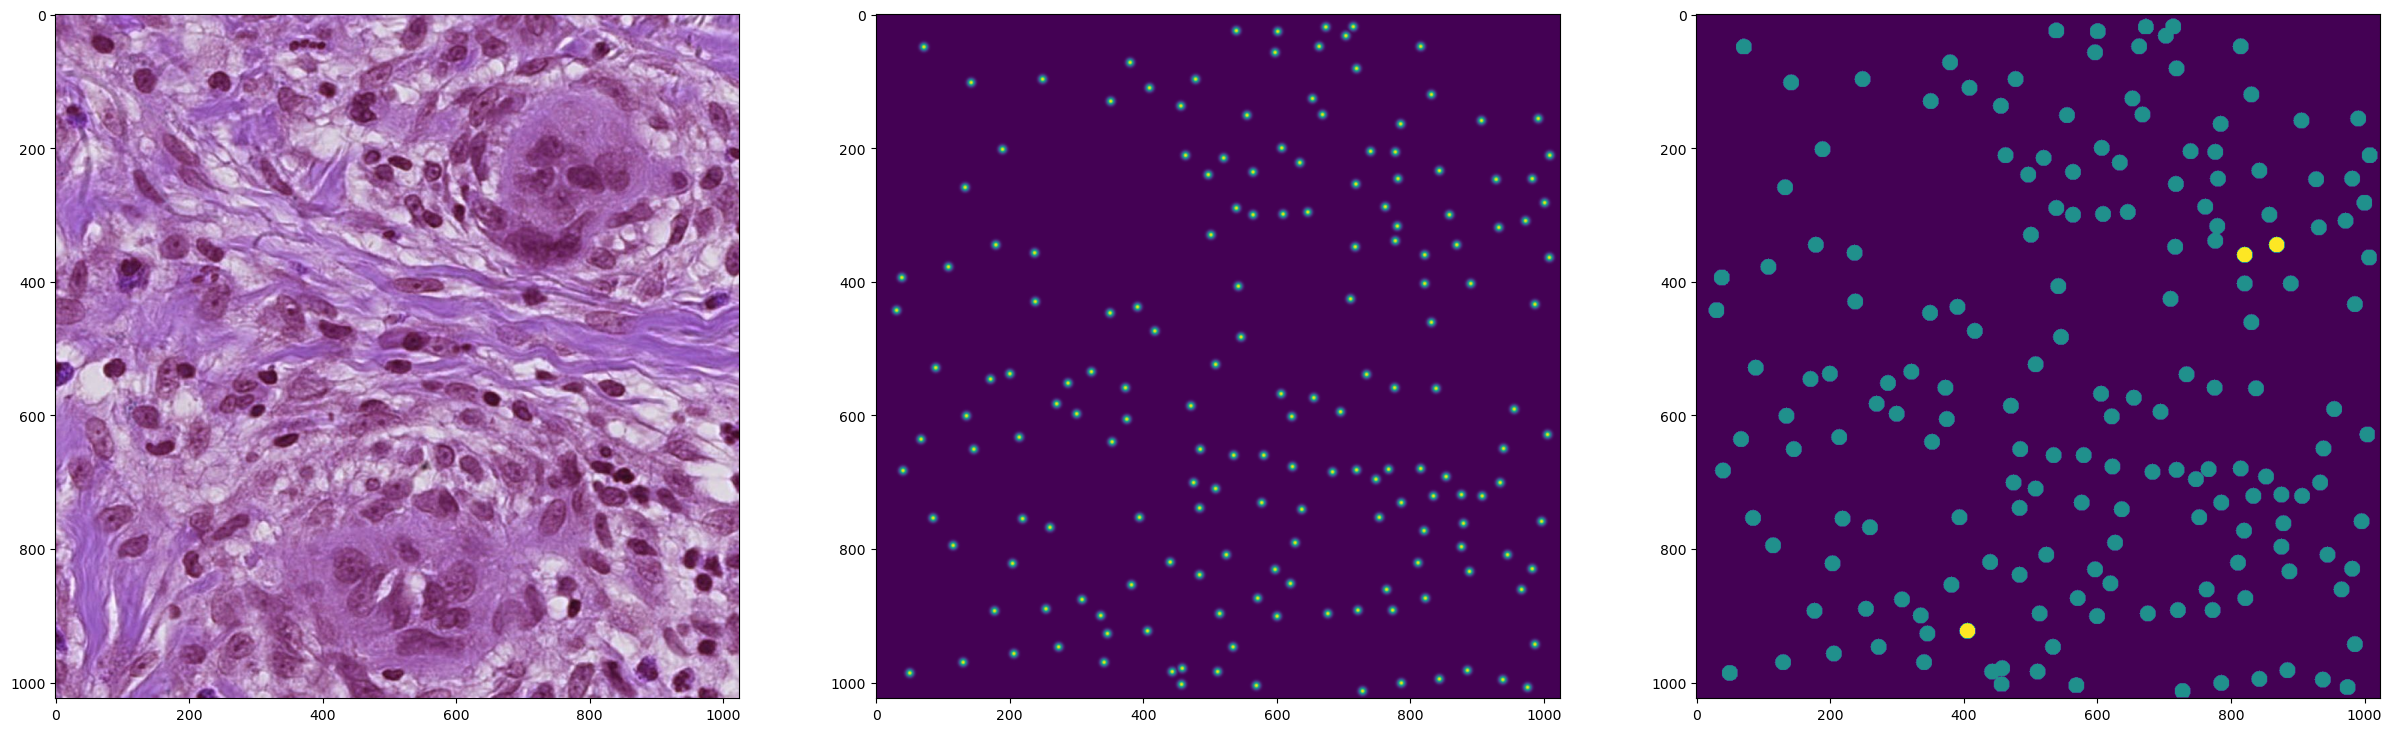

In [37]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig,axes = plt.subplots(1,3, figsize=(30,10))

deal_img = draw_bbox(img,boxes_with_scale) 
axes[0].imshow(img)
axes[1].imshow(heatmap)
axes[2].imshow(label)

### 处理完之后的数据目录应该是这样的
```
/ ocelot
├── annotations
│   ├── train
│   │   ├── cell
│   │   ├── tissue
│   │   ├── mask
│   │   └── heatmap
│   └── test
│       ├── cell
│       ├── tissue
│       ├── mask
│       └── heatmap
├── images
│   ├── train
│   │   ├── cell
│   │   └── tissue
│   └── test
│       ├── cell
│       └── tissue
└── metadata.json
```